### **Cargue de datos**


In [42]:
pip install pyspark

In [24]:
# Important Libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
from pyspark.sql.functions import col, to_date
import pyspark.sql.functions as f
from pyspark.sql.types import NumericType
import os 
from datetime import datetime
from pyspark.sql import types as t
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import missingno as msno
from pyspark.sql.functions import col

In [3]:
# WINDOWS - Compatible with VM
#path_jar_driver = 'C:\\Users\\Rodolfo\\OneDrive\\Maestria MIAD\\Semestre 1\\Ciclo 2\\Modelado de Datos y ETL\\Semana 2\\mysql-connector-j-9.0.0.jar'
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

# LINUX users: to download the jar wget https://dev.mysql.com/get/Downloads/Connector-J/mysql-connector-java-8.0.28.tar.gz
#path_jar_driver = '/opt/mysql/lib/mysql-connector-java-8.0.28.jar'

In [4]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [47]:
spark.stop()

In [5]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.120:8080/RaSaTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_52_202415'
db_psswd = 'Estudiante_202425423'

PATH='./'

In [6]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

In [7]:
try:
    # Verifica si el spark_context ya está creado
    if 'spark_context' in globals() and spark_context is not None:
        if spark_context._jsc is not None:  # Verifica si JavaSparkContext está activo
            print("Conexión a Spark exitosa.")
        else:
            print("Error: SparkContext no está inicializado correctamente.")
    else:
        print("Error: SparkContext no existe.")
except Exception as e:
    print(f"Error al verificar la conexión a Spark: {e}")

Conexión a Spark exitosa.


In [8]:
sql_FuenteCondicionesDePago_Copia_E = 'RaSaTransaccional.FuenteCondicionesDePago_Copia_E'
print(sql_FuenteCondicionesDePago_Copia_E)

RaSaTransaccional.FuenteCondicionesDePago_Copia_E


In [9]:
FuenteCondicionesDePago_Copia_E = obtener_dataframe_de_bd(db_connection_string, sql_FuenteCondicionesDePago_Copia_E, db_user, db_psswd)

## **Perfilamiento de datos**

### **Entendimiento de los datos**

In [10]:
FuenteCondicionesDePago_Copia_E.show(5)

+---------------------+--------------------+--------+
|IdCondicionesDePago_T|         Descripcion|    Tipo|
+---------------------+--------------------+--------+
|                  187|Copay with deduct...|  Copago|
|                  204|       Copay per Day|  Copago|
|                   45|         Coinsurance|Coseguro|
|                   85|Copay per Day bef...|  Copago|
|                   18|No Charge after d...|Coseguro|
+---------------------+--------------------+--------+
only showing top 5 rows



In [11]:
FuenteCondicionesDePago_Copia_E.schema

StructType(List(StructField(IdCondicionesDePago_T,IntegerType,true),StructField(Descripcion,StringType,true),StructField(Tipo,StringType,true)))

In [12]:
print((FuenteCondicionesDePago_Copia_E.count(), len(FuenteCondicionesDePago_Copia_E.columns)))

(31, 3)


In [13]:
FuenteCondicionesDePago_Copia_E.describe().show()

+-------+---------------------+--------------+-------------+
|summary|IdCondicionesDePago_T|   Descripcion|         Tipo|
+-------+---------------------+--------------+-------------+
|  count|                   31|            31|           31|
|   mean|   152.16129032258064|          null|          NaN|
| stddev|   161.75312398306122|          null|          NaN|
|    min|                    9|   Coinsurance|     Copagado|
|    max|                  714|Not Applicable|SinTipoCopago|
+-------+---------------------+--------------+-------------+



In [13]:
Vrunicos = FuenteCondicionesDePago_Copia_E.distinct().count() 
print(f"Valores únicos en 'IdCondicionesDePago_T': {Vrunicos}")

Valores únicos en 'IdCondicionesDePago_T': 24


La tabla FuenteCondicionesDePago_Copia_E contiene la información de las condiciones de pago asociadas a cada uno de los planes de beneficios de la seguridad social. Esta tabla es importante porque permite medir el costo de dichos planes de beneficios.

La variable “idCondicionesDePago_T” es de tipo Integer, la variable “Descripcion” es de tipo String y la variable “Tipo” también es de tipo String. 

Cada fila registra el tipo de condición de pago, copago, coseguro o pago anticipado, que se asocia con un plan de beneficios existente; además, incluye el nombre y el identificador. 

La tabla está compuesta por 31 registros, de los cuales 24 son registros únicos. La llave primaria es la variable idCondicionesDePago_T. 

### **Revisión de reglas de negocio:** 

Existen 15 y 5 diferentes condiciones de pago y cooseguro respectivamente

In [27]:
total_condiciones_pago = FuenteCondicionesDePago_Copia_E.select("IdCondicionesDePago_T").distinct().count()
print("Cantidad total de condiciones de pago existentes:", total_condiciones_pago)

# Contar la cantidad de registros donde Tipo es "cooseguro"
cantidad_tipo_cooseguro = FuenteCondicionesDePago_Copia_E.filter(col("Tipo") == "coseguro").distinct().count()
print("Cantidad de registros con Tipo 'coseguro':", cantidad_tipo_cooseguro)

Cantidad total de condiciones de pago existentes: 23
Cantidad de registros con Tipo 'coseguro': 5


La empresa nos informa que existen 15 condiciones de copago y 5 de coseguro, respectivamente al revisar la información de la tabla, se observa que este dato es correcto. 

### **Análisis de calidad de datos**

#### **Unicidad y Validez de los datos**

In [15]:
# Unicidad
total_registros = FuenteCondicionesDePago_Copia_E.count()
registros_sin_duplicados = FuenteCondicionesDePago_Copia_E.dropDuplicates()
duplicados = total_registros - registros_sin_duplicados.count()
print(f"Cantidad de registros duplicados: {duplicados}")

Cantidad de registros duplicados: 7


In [16]:
# Validez
#Verificar que IDs sean positivos
invalid_ids = FuenteCondicionesDePago_Copia_E.filter(col("IdCondicionesDePago_T") < 0).count()
print("Número de IDs inválidos:", invalid_ids)

Número de IDs inválidos: 0


#### **Completitud y Consistencia de los datos**

In [19]:
# Completitud
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    if not resultados:
       print("No existen valores vacíos")
    return resultados

columnas_vacias = contar_vacios(FuenteCondicionesDePago_Copia_E)
print(columnas_vacias)


No existen valores vacíos
[]


In [38]:
# Consistencia
FuenteCondicionesDePago_Copia_E = FuenteCondicionesDePago_Copia_E.dropDuplicates()
FuenteCondicionesDePago_Copia_E.groupBy("Descripcion").count().orderBy("count", ascending=False).show()
FuenteCondicionesDePago_Copia_E.groupBy("Tipo").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|         Descripcion|count|
+--------------------+-----+
|No Charge after d...|    2|
|         Coinsurance|    2|
|               Copay|    2|
|           No Charge|    2|
|      Not Applicable|    2|
|Copay per Stay af...|    2|
|      Copay per Stay|    2|
|Coinsurance after...|    1|
|Copay before dedu...|    1|
|Copay with deduct...|    1|
|Copay per Day wit...|    1|
|Copay per Stay wi...|    1|
|Copay after deduc...|    1|
|Copay per Day bef...|    1|
|       Copay per Day|    1|
|Copay per Day aft...|    1|
|Copay per Stay be...|    1|
+--------------------+-----+

+-------------+-----+
|         Tipo|count|
+-------------+-----+
|       Copago|   15|
|     Coseguro|    5|
|     Copagado|    1|
|  Coseguridad|    1|
|          NaN|    1|
|SinTipoCopago|    1|
+-------------+-----+



Teniendo en cuenta que es una tabla con pocos registros y solo tres variables, dos de tipo string y una de tipo integer que actúa como identificador, se obtienen los siguientes resultados: 

Se registran únicamente dos valores vacíos en la columna Tipo. 

Siete de los 31 registros son duplicados. Aunque es un porcentaje significativo, estos registros deben ser eliminados. 

### **Analisis Descriptivo**

In [22]:
estadisticasdes = FuenteCondicionesDePago_Copia_E.summary()
estadisticasdes.show()

+-------+---------------------+--------------+-------------+
|summary|IdCondicionesDePago_T|   Descripcion|         Tipo|
+-------+---------------------+--------------+-------------+
|  count|                   31|            31|           31|
|   mean|   152.16129032258064|          null|          NaN|
| stddev|   161.75312398306122|          null|          NaN|
|    min|                    9|   Coinsurance|     Copagado|
|    25%|                   45|          null|          NaN|
|    50%|                  119|          null|          NaN|
|    75%|                  204|          null|          NaN|
|    max|                  714|Not Applicable|SinTipoCopago|
+-------+---------------------+--------------+-------------+



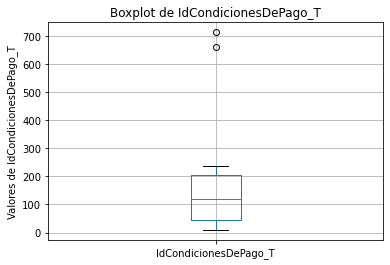

In [26]:
df_FuenteCondicionesDePago_Copia_E = FuenteCondicionesDePago_Copia_E.toPandas()
df_FuenteCondicionesDePago_Copia_E.boxplot(column='IdCondicionesDePago_T')
plt.title("Boxplot de IdCondicionesDePago_T")
plt.ylabel("Valores de IdCondicionesDePago_T")
plt.show()

Se destaca en la variable “idCondicionesDePago_T” el valor mínimo de 9 y máximo de 714, lo que muestra una dispersión de los datos que además no guarda una secuencia incremental, característica propia en el identificador de este tipo de tablas. 

La frecuencia relativa muestra que, de los 23 registros únicos de condiciones de pago, 15 corresponden a copago, 5 a coseguro  y 3 a otras condiciones de pago, además existen 2 registros NaN. 

### Conclusiones

Las conclusiones se incluyen en el informe de presentación "Entendimiento de los datos".
